In [1]:
uv add python-dotenv langgraph langsmith "langchain[anthropic]" langchain-tavily

Note: you may need to restart the kernel to use updated packages.


Resolved 48 packages in 0.77ms
Audited 47 packages in 2ms


In [2]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns/langgraph',
   'title': 'LangGraph | Arize Phoenix',
   'content': '*   [Agent Cookbooks](https://arize.com/docs/phoenix/cookbook/agent-cookbooks) *   [Agent Demos](https://arize.com/docs/phoenix/cookbook/agent-demos) *   [Agent Workflow Patterns](https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns) *   [AutoGen](https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns/autogen) *   [CrewAI](https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns/crewai) *   [Google GenAI SDK (Manual Orchestration)](https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns/google-genai-sdk-manual-orchestration) *   [OpenAI Agents](https://arize.com/docs/phoenix/cookbook/agent-workflow-patterns/openai-agents) *   [LangGraph](https://arize.com/docs/phoenix/cookbook/agent-workflow-patte

In [5]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model("claude-sonnet-4-5-20250929")

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


In [6]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)
# graph = graph_builder.compile()

In [8]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [9]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

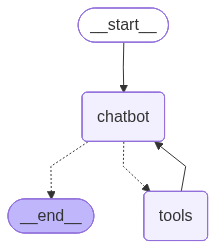

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?


ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [12]:
config = {"configurable": {"thread_id": "1"}}

In [13]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! Nice to meet you! How can I help you today?


In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember! Your name is Will. What can I help you with today?


In [15]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have any previous memory of your name or our past conversations. Each conversation I have starts fresh without access to previous interactions.

If you'd like to tell me your name, I'd be happy to use it during our current conversation! However, I won't be able to remember it in future conversations.


In [16]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='9eb03ed0-abbe-4cc1-9299-aad551fd2de3'), AIMessage(content='Hello Will! Nice to meet you! How can I help you today?', additional_kwargs={}, response_metadata={'id': 'msg_019YhNvhNB4dCYYtCfVqoRUF', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 2308, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-sonnet-4-5-20250929', 'model_provider': 'anthropic'}, id='lc_run--707835c1-3d86-4886-b07b-31af73d1ac78-0', usage_metadata={'input_tokens': 2308, 'output_tokens': 18, 'total_tokens': 2326, 'input_token_details': {'cache_creation': 0, 'cache_read': 0, 'ephemeral_5m_input_tokens': 0, 'ephemeral_1h_input_to